In [1]:
from keras.models import load_model
from keras.models import model_from_json

json_file = open('/kaggle/input/handwritten-char-digit-math-symbol/other/json_model/1/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)


loaded_model.load_weights('/kaggle/input/handwritten-char-digit-math-symbol/other/model/1/model_weights.weights.h5')

model = loaded_model


print('Model successfully loaded')

2024-03-21 12:43:52.255908: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-21 12:43:52.256049: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-21 12:43:52.421654: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Model successfully loaded


In [2]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 53)             │        27,189 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,894,209 (60.63 MB)

 Trainable params: 5,298,069 (20.21 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,596,140 (40.42 MB)

In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

characters = ['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','a','b','d','e','f','g','h','n','q','r','t','(',')','+','-','=','÷']


In [4]:
import os
import cv2
import numpy as np

# import matplotlib.pyplot as plt

OUTPUT_DIR = os.path.join('/kaggle/working', "segmented")


def line_array(x):
    upper, lower = [], []
    for y in range(5, len(x) - 5):
        s_a, s_p = strtline(y, x)
        e_a, e_p = endline(y, x)
        if s_a >= 7 and s_p >= 5:
            upper.append(y)
        if e_a >= 5 and e_p >= 7:
            lower.append(y)
    return upper, lower


def strtline(y, array):
    prev, ahead = 0, 0
    for i in array[y : y + 10]:
        if i > 3:
            ahead += 1
    for i in array[y - 10 : y]:
        if i == 0:
            prev += 1
    return ahead, prev


def endline(y, array):
    ahead = 0
    prev = 0
    for i in array[y : y + 10]:
        if i == 0:
            ahead += 1
    for i in array[y - 10 : y]:
        if i > 3:
            prev += 1
    return ahead, prev


def endline_word(y, array, a):
    ahead = 0
    prev = 0
    for i in array[y : y + 2 * a]:
        if i < 2:
            ahead += 1
    for i in array[y - a : y]:
        if i > 2:
            prev += 1
    return prev, ahead


def end_line_array(array, a):
    list_endlines = []
    for y in range(len(array)):
        e_p, e_a = endline_word(y, array, a)
        # print(e_p, e_a)
        if e_a >= int(1.5 * a) and e_p >= int(0.7 * a):
            list_endlines.append(y)
    return list_endlines


def refine_endword(array):
    refine_list = []
    for y in range(len(array) - 1):
        if array[y] + 1 < array[y + 1]:
            refine_list.append(array[y])

    if len(array) != 0:
        refine_list.append(array[-1])
    return refine_list


def refine_array(array_upper, array_lower):
    upper, lower = [], []
    for y in range(len(array_upper) - 1):
        if array_upper[y] + 5 < array_upper[y + 1]:
            upper.append(array_upper[y] - 10)
    for y in range(len(array_lower) - 1):
        if array_lower[y] + 5 < array_lower[y + 1]:
            lower.append(array_lower[y] + 10)
    if array_upper:
        upper.append(array_upper[-1] - 10)
    if array_lower:
        lower.append(array_lower[-1] + 10)
    return upper, lower


def letter_width(contours):
    letter_width_sum = 0
    count = 0
    for cnt in contours:
        if cv2.contourArea(cnt) > 20:
            x, y, w, h = cv2.boundingRect(cnt)
            letter_width_sum += w
            count += 1
    if count == 0:
        return 0
    return letter_width_sum / count


def end_wrd_dtct(lines, i, bin_img, mean_lttr_width, total_width):
    count_y = np.zeros(shape=total_width)
    for x in range(total_width):
        for y in range(lines[i][0], lines[i][1]):
            if bin_img[y][x] == 255:
                count_y[x] += 1

    end_lines = end_line_array(count_y, int(mean_lttr_width))
    endlines = refine_endword(end_lines)
    return endlines


def get_letter_rect(k, contours):
    valid = True
    x, y, w, h = cv2.boundingRect(contours[k])
    for i in range(len(contours)):
        cnt = contours[i]
        if i == k:
            continue
        elif cv2.contourArea(cnt) < 50:
            continue

        x1, y1, w1, h1 = cv2.boundingRect(cnt)

        if abs(x1 + w1 / 2 - (x + w / 2)) < 50:
            if y1 > y:
                h = abs(y - (y1 + h1))
                w = abs(x - (x1 + w1))
            else:
                valid = False
            break

    return (valid, x, y, w, h)


def letter_seg(lines_img, x_lines, i):
    copy_img = lines_img[i].copy()
    x_linescopy = x_lines[i].copy()

    letter_img = []
    letter_k = []

    contours, hierarchy = cv2.findContours(
        copy_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    for k in range(len(contours)):
        cnt = contours[k]
        if cv2.contourArea(cnt) < 50:
            continue

        valid, x, y, w, h = get_letter_rect(k, contours)
        if valid:
            letter_k.append((x, y, w, h))

    letter = sorted(letter_k, key=lambda student: student[0])

    word = 1
    letter_index = 0
    for e in range(len(letter)):
        if letter[e][0] < x_linescopy[0]:
            letter_index += 1
            letter_img_tmp = lines_img[i][
                letter[e][1] - 5 : letter[e][1] + letter[e][3] + 5,
                letter[e][0] - 5 : letter[e][0] + letter[e][2] + 5,
            ]
            letter_img = letter_img_tmp  # cv2.resize(letter_img_tmp, dsize =(28, 28), interpolation = cv2.INTER_AREA)
            cv2.imwrite(
                os.path.join(
                    OUTPUT_DIR,
                    str(i + 1) + "_" + str(word) + "_" + str(letter_index) + ".jpg",
                ),
                255 - letter_img,
            )
        else:
            x_linescopy.pop(0)
            word += 1
            letter_index = 1
            letter_img_tmp = lines_img[i][
                letter[e][1] - 5 : letter[e][1] + letter[e][3] + 5,
                letter[e][0] - 5 : letter[e][0] + letter[e][2] + 5,
            ]
            letter_img = cv2.resize(
                letter_img_tmp, dsize=(28, 28), interpolation=cv2.INTER_AREA
            )
            cv2.imwrite(
                OUTPUT_DIR
                + str(i + 1)
                + "_"
                + str(word)
                + "_"
                + str(letter_index)
                + ".jpg",
                255 - letter_img,
            )



In [28]:
image_list = []

In [29]:
def save_segmented_images(filepath, output_folder, output_folder_segmented):
    print("\n........Program Initiated.......\n")
    src_img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    if len(set(src_img.flatten())) == 1:
        src_img = cv2.imread(filepath, cv2.IMREAD_COLOR)[:, :, 0]
    orig_height, orig_width = src_img.shape

    print("\n Resizing Image........")
    width = 1320
    height = int(width * orig_height / orig_width)
    src_img = cv2.resize(src_img, dsize=(width, height), interpolation=cv2.INTER_AREA)

    print("#---------Image Info:--------#")
    print("\tHeight =", height, "\n\tWidth =", width)
    PIXEL_SET = 255
    kernel_size = 21
    normalized_mean = 20
    bin_img = cv2.adaptiveThreshold(
        src_img,
        PIXEL_SET,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY_INV,
        kernel_size,
        normalized_mean,
    )

    print("Noise Removal")
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    final_thr = cv2.morphologyEx(bin_img, cv2.MORPH_CLOSE, kernel)
    contr_retrival = final_thr.copy()
    print("Character Segmentation")
    count_x = np.zeros(shape=(height))
    for y in range(height):
        for x in range(width):
            if bin_img[y][x] == PIXEL_SET:
                count_x[y] += 1

    upper_lines, lower_lines = line_array(count_x)
    upperlines, lowerlines = refine_array(upper_lines, lower_lines)

    if len(upperlines) == len(lowerlines):
        lines = []
        for y in upperlines:
            final_thr[y][:] = PIXEL_SET
        for y in lowerlines:
            final_thr[y][:] = PIXEL_SET
        for y in range(len(upperlines)):
            lines.append((upperlines[y], lowerlines[y]))
    else:
        print("Unable to process the noisy image")
        k = cv2.waitKey(0)
        while 1:
            k = cv2.waitKey(0)
            if k & 0xFF == ord("q"):
                cv2.destroyAllWindows()
                exit()

    lines = np.array(lines)
    no_of_lines = len(lines)
    print("\nLines :", no_of_lines)

    lines_img = []
    for i in range(no_of_lines):
        lines_img.append(bin_img[lines[i][0] : lines[i][1], :])

    contours, hierarchy = cv2.findContours(
        contr_retrival, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    cv2.drawContours(src_img, contours, -1, (0, 255, 0), 1)

    mean_lttr_width = letter_width(contours)
    print("\nAverage Width of Each Letter:- ", mean_lttr_width)
    x_lines = []

    for i in range(len(lines_img)):
        x_lines.append(end_wrd_dtct(lines, i, bin_img, mean_lttr_width, width))

    for i in range(len(x_lines)):
        x_lines[i].append(width)
    for i in range(len(lines)):
        letter_seg(lines_img, x_lines, i)
    contours, hierarchy = cv2.findContours(
        bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    # Ensure the output directory exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    if not os.path.exists(output_folder_segmented):
        os.makedirs(output_folder_segmented)
    
    # Sort contours based on x-coordinate
    contours = sorted(contours, key=lambda x: cv2.boundingRect(x)[0])
    
    # Save each contour as a separate image
    for i, cnt in enumerate(contours):
        if cv2.contourArea(cnt) > 20:
            x, y, w, h = cv2.boundingRect(cnt)
            # Extract the contour region from the original image
            contour_region = src_img[y:y+h, x:x+w]
            # Save the contour region as a separate image
            image = os.path.join(output_folder_segmented, f"segment_{i}.jpg")
            image_list.append(image)
            cv2.imwrite(image, contour_region)

    # Draw bounding boxes on the original image
    for cnt in contours:
        if cv2.contourArea(cnt) > 20:
            x, y, w, h = cv2.boundingRect(cnt)
            cv2.rectangle(src_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Save the combined image with bounding boxes
    cv2.imwrite(os.path.join(output_folder, "combined_image.jpg"), src_img)

    print(f"Segmented images saved in '{output_folder}' folder, along with the combined image.")

# Example usage
save_segmented_images('/kaggle/input/example13/ex13.jpg', '/kaggle/working/segmented', '/kaggle/working/segmented_images')


........Program Initiated.......


 Resizing Image........
#---------Image Info:--------#
	Height = 332 
	Width = 1320
Noise Removal
Character Segmentation

Lines : 1

Average Width of Each Letter:-  169.83333333333334
Segmented images saved in '/kaggle/working/segmented' folder, along with the combined image.


In [30]:
image_list

['/kaggle/working/segmented_images/segment_0.jpg',
 '/kaggle/working/segmented_images/segment_1.jpg',
 '/kaggle/working/segmented_images/segment_2.jpg',
 '/kaggle/working/segmented_images/segment_3.jpg',
 '/kaggle/working/segmented_images/segment_4.jpg',
 '/kaggle/working/segmented_images/segment_5.jpg']

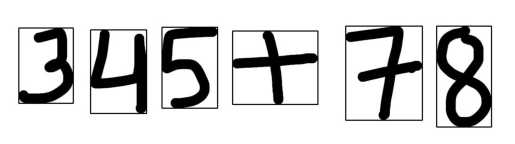

In [31]:
import matplotlib.pyplot as plt

image = cv2.imread('/kaggle/working/segmented/combined_image.jpg')
plt.imshow(image)
plt.axis('off')
plt.show()

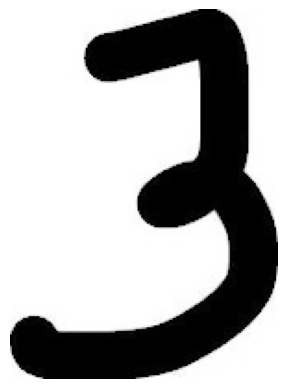

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


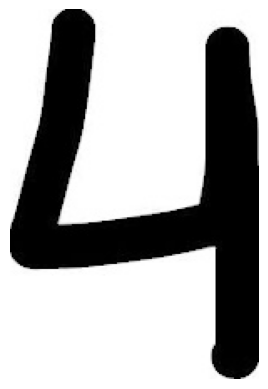

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


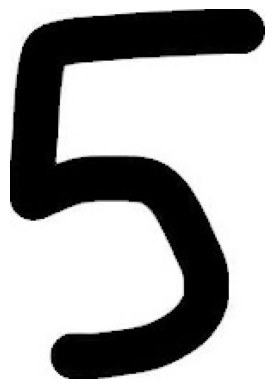

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


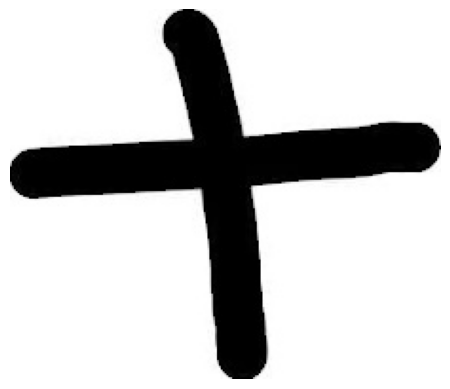

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


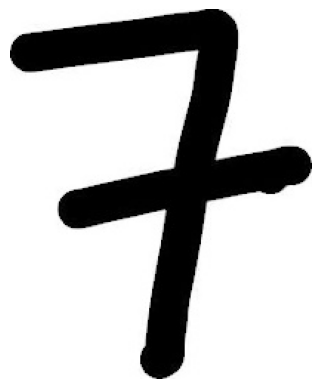

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


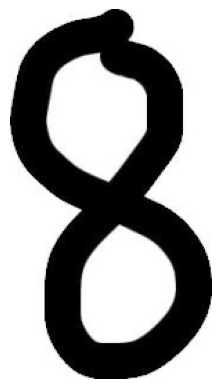

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


[[14], [4], [2], [49], [16], [44]]

In [32]:
import cv2
import numpy as np

# Define target image size
target_size = (28, 28)

pchl = []
for t in image_list:
    image = cv2.imread(t)
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    # Resize image
    resized_image = cv2.resize(image, target_size)
    # Convert image to grayscale
    grayscale_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    # Flatten image
    flattened_image = grayscale_image.flatten()
    # Normalize pixel values
    
    normalized_image = flattened_image / 255.0
    # Reshape to match expected input shape
    reshaped_image = normalized_image.reshape(1, -1)  # Reshape to (1, 784)
    # Predict using the model
    pred_probs = model.predict(reshaped_image)
    pred_class = np.argmax(pred_probs)
    pchl.append([pred_class])

pchl


In [34]:
s = ''
for i in range(len(pchl)):
    print(characters[pchl[i][0]])
    s+=characters[pchl[i][0]]

E
4
2
+
G
q


In [35]:
s

'E42+Gq'

# Wolfram Alpha

In [36]:
pip install wolframalpha

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [40]:
# importing the wolframalpha module  
import wolframalpha  
  
# defining a function to find answer  
def find_answer(question):  
    """This function will return the answer 
    for the input query from the users"""  
  
    # declaring a variable to store the APP ID  
    app_id = 'E3RYX3-G73QUJ4VY7'  
  
    # creating an object of the Client() class using the APP ID  
    the_client = wolframalpha.Client(app_id)  
  
    # storing the responses from wolfram alpha  
    response = the_client.query(question)  
  
    # including only the text from the responses  
    answer = next(response.results).text  
  
    # returning the answer  
    return answer  
  
# main function  
if __name__ == '__main__':  
  
    # using the input() function to accept a question from the user  
    question = input("Question: ")  
  
    # calling the find_answer() function by passing the input question  
    answer = find_answer(question)  
  
    # printing the answer for the user  
    print("Answer:", answer)  

Question:  3x+7=0


Answer: x = -7/3
